In [68]:
import os
import numpy as np
import pyarrow as pa
import pyarrow.compute as pc
import pyarrow.parquet as pq

DATA_DIR = '/aiomics/massspec_cache/nist/aiomics/take_two/'
#DATA_DIR = '.'
DATA_SUBDIRS = [ "original", "consensus_small", "consensus" ]
FILES = [ "test", "validation", "training" ]
COLUMNS = ["id", "charge", "peptide_len", "nce", "mod_names", "is_phospho"]

def read_data(basedir, subdir, file, columns=COLUMNS):
    table_name = os.path.join(basedir, subdir, file + ".parquet")
    #print(table_name)
    table = pq.read_table(table_name, columns=columns)

    #print(f"Read {table.num_rows} rows from {table_name}")
    return table

def count_spectra_with_mods(table):
    vc = pc.value_counts(pc.list_value_length(table.column("mod_names")))
    num_mods = 0
    for a,b in zip(vc.field(0), vc.field(1)):
        if a.as_py() > 0:
            num_mods += b.as_py()
    return num_mods/table.num_rows*100

def count_spectra_with_phospho(table):
    #print(table.column("mod_names"))
    vc = pc.value_counts(table.column("is_phospho"))
    num_phospho = 0
    for a,b in zip(vc.field(0), vc.field(1)):
        if a.as_py() > 0:
            num_phospho += b.as_py()
    #return num_phospho/table.num_rows*100
    return num_phospho

def compute_stats(base_dir, subdir):
    full_table = None
    for file in FILES:
        table = read_data(base_dir, subdir, file)
        print(f"File: {file}")
        print(f"\tSpectra: {table.num_rows}")
        print(f"\tMean peptide length: {pc.mean(table.column('peptide_len')).as_py():.1f}")
        print(f"\tMods: {count_spectra_with_mods(table):.1f}%")
        print(f"\tPhospho: {count_spectra_with_phospho(table):.1f}%")
        subtable = table.select(["charge", "peptide_len", "nce"]).append_column("dataset", pa.array([file for x in range(table.num_rows)]))
        if full_table == None:
            full_table = subtable
        else:
            full_table = pa.concat_tables([full_table, subtable])
    return full_table

table = compute_stats(DATA_DIR, "consensus")

File: test
	Spectra: 14502
	Mean peptide length: 19.2
	Mods: 55.7%
	Phospho: 907.0%
File: validation
	Spectra: 5575
	Mean peptide length: 19.3
	Mods: 56.4%
	Phospho: 428.0%
File: training
	Spectra: 2335082
	Mean peptide length: 14.7
	Mods: 52.7%
	Phospho: 81333.0%


In [67]:
df = table.to_pandas()
dfCount = df[['charge','dataset']].groupby(by="dataset").count().reset_index()
dfIn = df.query('charge >= 2 & charge <= 4 & peptide_len >= 6 & peptide_len <= 30 & nce >= 15 & nce <= 70')[['charge','dataset']].groupby(by="dataset").count().reset_index()
dfOut = df.query('charge < 2 | charge > 4 | peptide_len < 6 | peptide_len > 30 | nce < 15 | nce > 70')[['charge','dataset']].groupby(by="dataset").count().reset_index()
print(dfCount)
print()
print(dfIn['charge']/dfCount['charge'])
print()
print(dfOut['charge']/dfCount['charge'])

      dataset   charge
0        test    14502
1    training  2335082
2  validation     5575

0    0.943111
1    0.964707
2    0.942242
Name: charge, dtype: float64

0    0.056889
1    0.035293
2    0.057758
Name: charge, dtype: float64


In [66]:
df.query('charge < 2 | charge > 4 | peptide_len < 6 | peptide_len > 30 | nce < 15 | nce > 70')

,charge,peptide_len,nce,dataset
23,4,35,34.0,test
36,3,31,34.0,test
39,3,32,35.0,test
105,2,33,34.0,test
106,3,33,28.0,test
...,...,...,...,...
2354548,4,32,30.0,training
2354549,4,32,35.0,training
2354861,5,27,25.0,training
2354862,5,27,30.0,training


In [54]:
print(a)
a.reset_index()['charge'] / b.reset_index()['charge']

             charge
dataset            
test          13677
training    2252670
validation     5253


0    0.943111
1    0.964707
2    0.942242
Name: charge, dtype: float64

charge                                             
                count      mean       std  min  25%  50%  75%  max
dataset                                                           
test          14502.0  2.818646  0.748446  2.0  2.0  3.0  3.0  8.0
training    2335082.0  2.598918  0.737671  0.0  2.0  2.0  3.0  9.0
validation     5575.0  2.813632  0.742063  1.0  2.0  3.0  3.0  7.0

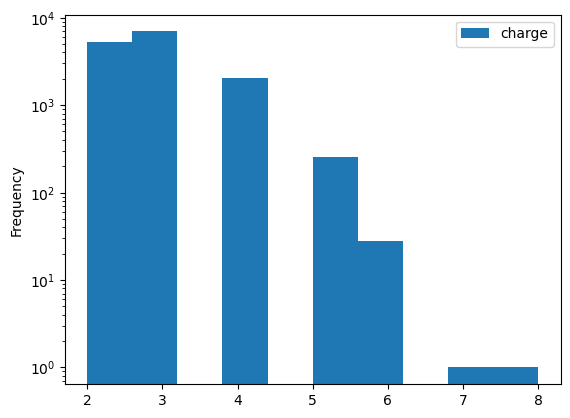

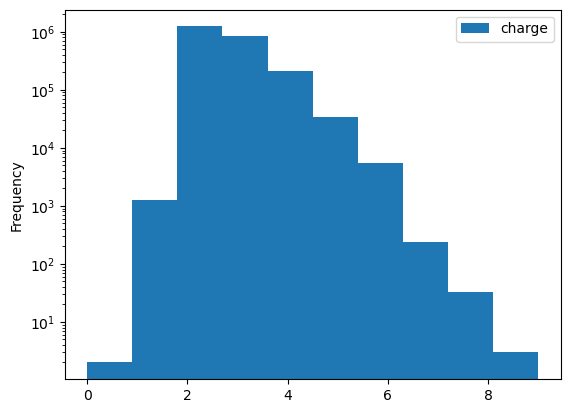

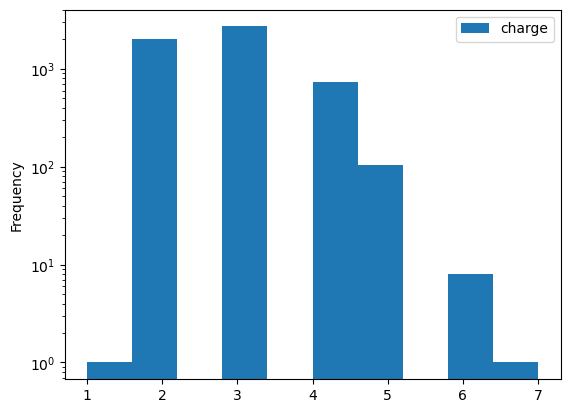

In [28]:
table.select(["charge", "dataset"]).to_pandas().groupby(by="dataset").plot.hist(logy=True)
table.select(["charge", "dataset"]).to_pandas().groupby(by="dataset").describe()

peptide_len                                                  
                 count       mean       std  min   25%   50%   75%   max
dataset                                                                 
test           14502.0  19.209764  5.613570  6.0  15.0  18.0  22.0  50.0
training     2335082.0  14.694511  6.076434  5.0  10.0  13.0  18.0  52.0
validation      5575.0  19.304215  5.858884  6.0  15.0  18.0  22.0  50.0

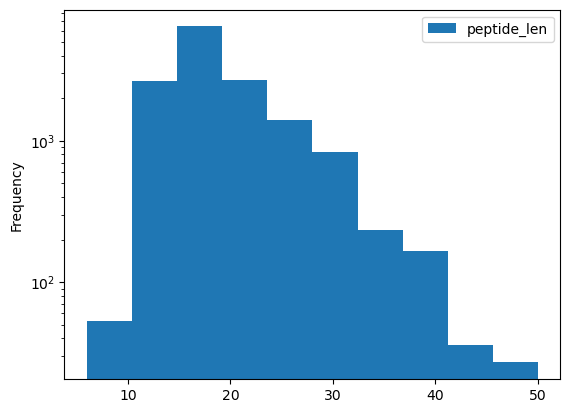

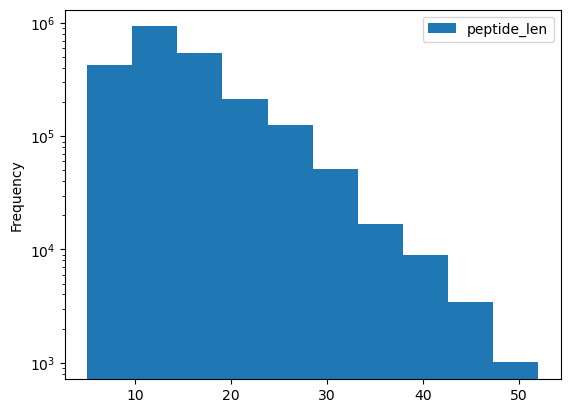

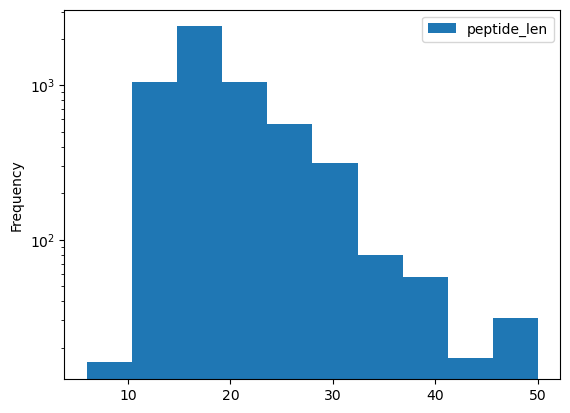

In [29]:
table.select(["peptide_len", "dataset"]).to_pandas().groupby(by="dataset").plot.hist(logy=True)
table.select(["peptide_len", "dataset"]).to_pandas().groupby(by="dataset").describe()

nce                                                     
                count       mean       std  min      25%   50%   75%   max
dataset                                                                   
test          14502.0  30.602272  4.407886  0.0  26.7625  30.0  35.0  45.0
training    2335082.0  31.025484  4.366579  0.0  28.0000  30.0  35.0  45.0
validation     5575.0  30.465207  4.394699  0.0  26.2450  30.0  35.0  45.0

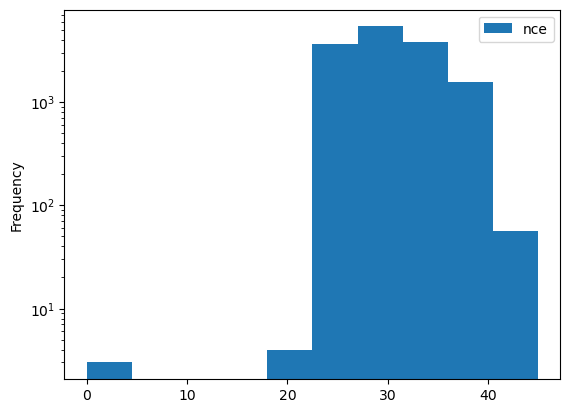

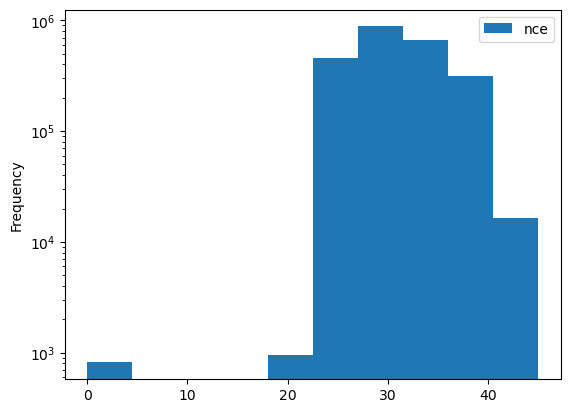

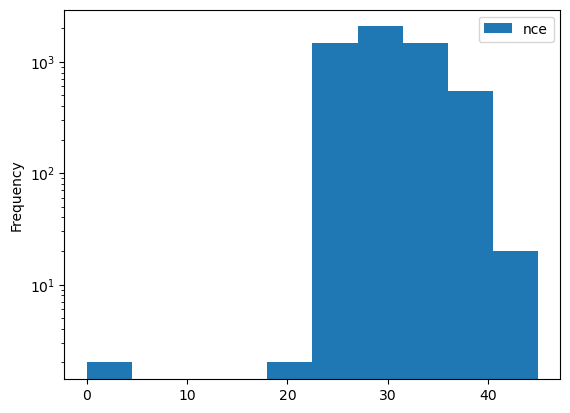

In [30]:
table.select(["nce", "dataset"]).to_pandas().groupby(by="dataset").plot.hist(logy=True)
table.select(["nce", "dataset"]).to_pandas().groupby(by="dataset").describe()

In [55]:
def print_counts(vc, size):
    for a,b in zip(vc.field(0), vc.field(1)):
        print(f"{a}:\t{(b.as_py()/size)*100:.2f}%")

for file in FILES:
    table = read_data(".", ".", file)
    res = pc.value_counts(table.column("charge"))
    print_counts(res, table.num_rows)
    print()

2:	56.62%
3:	35.31%
4:	7.18%
5:	0.76%
6:	0.13%

2:	57.33%
3:	34.25%
4:	7.56%
5:	0.76%
6:	0.10%

2:	56.96%
3:	34.92%
4:	7.27%
5:	0.76%
1:	0.01%
6:	0.09%
7:	0.01%
8:	0.00%



In [51]:
#table = read_data(DATA_DIR, DATA_SUBDIRS[0], FILES[0])

def print_histogram(col):
    #v, b = np.histogram(table['nce'].to_numpy(), bins=20)
    v, b = np.histogram(col.to_numpy(), bins=20)
    for i in range(len(v)):
        print(f'{(b[i]+b[i+1])/2:.2f}:\t{v[i]}')

for col in COLUMNS[1:]:
    print(col)
    for subdir in DATA_SUBDIRS:
        print(subdir)
        for file in FILES:
            print(file)
            table = read_data(DATA_DIR, subdir, file)
            print_histogram(table[col])
            print()
    print("--- \n")


peptide_len
original
test.parquet
7.30:	17
9.90:	236
12.50:	1695
15.10:	5195
17.70:	2883
20.30:	2836
22.90:	1727
25.50:	589
28.10:	728
30.70:	201
33.30:	208
35.90:	101
38.50:	41
41.10:	47
43.70:	15
46.30:	30
48.90:	3
51.50:	0
54.10:	0
56.70:	1

validation.parquet
8.05:	23
10.15:	62
12.25:	516
14.35:	1238
16.45:	1051
18.55:	774
20.65:	699
22.75:	358
24.85:	306
26.95:	192
29.05:	154
31.15:	29
33.25:	21
35.35:	23
37.45:	18
39.55:	7
41.65:	2
43.75:	3
45.85:	4
47.95:	1

training.parquet
6.55:	194854
9.65:	417829
12.75:	404411
15.85:	284913
18.95:	184010
22.05:	103469
25.15:	57851
28.25:	32999
31.35:	16779
34.45:	8329
37.55:	5186
40.65:	1727
43.75:	797
46.85:	475
49.95:	184
53.05:	43
56.15:	19
59.25:	4
62.35:	0
65.45:	1

consensus_small
test.parquet
7.10:	24
9.30:	88
11.50:	1012
13.70:	3589
15.90:	3663
18.10:	4553
20.30:	1871
22.50:	1446
24.70:	1018
26.90:	579
29.10:	794
31.30:	204
33.50:	175
35.70:	105
37.90:	113
40.10:	56
42.30:	33
44.50:	22
46.70:	20
48.90:	23

validation.parquet
8.07:	29

In [45]:
table = read_data(DATA_DIR, DATA_SUBDIRS[0], FILES[0])
vc = pc.value_counts(table.column(COLUMNS[0]))
pa.table(vc.flatten())

ValueError: Must pass names or schema when constructing Table or RecordBatch.

In [38]:
def read_data(basedir, subdir, file, columns=COLUMNS):
    table_name = os.path.join(basedir, subdir, file)
    #print(table_name)
    table = pq.read_table(table_name, columns=columns)

    #print(f"Read {table.num_rows} rows from {table_name}")
    return table

def print_counts(vc, size):
    for a,b in zip(vc.field(0), vc.field(1)):
        print(f"{a}:\t{(b.as_py()/size)*100:.2f}%")

for col in COLUMNS:
    print(col)
    for subdir in DATA_SUBDIRS:
        print(subdir)
        for file in FILES:
            print(file)
            table = read_data(DATA_DIR, subdir, file)
            res = pc.value_counts(table.column(col))
            print_counts(res, table.num_rows)
            print()
    print("--- \n")


charge
original
test.parquet
2:	44.24%
3:	45.51%
4:	9.32%
5:	0.84%
6:	0.08%
1:	0.01%

validation.parquet
2:	46.09%
3:	44.33%
4:	8.87%
5:	0.66%
1:	0.04%
6:	0.02%

training.parquet
2:	61.21%
3:	31.38%
4:	6.09%
5:	0.61%
1:	0.65%
7:	0.01%
6:	0.06%
8:	0.00%

consensus_small
test.parquet
2:	43.51%
3:	44.55%
4:	10.66%
5:	1.20%
6:	0.08%
7:	0.01%

validation.parquet
3:	44.46%
2:	43.33%
4:	10.84%
5:	1.18%
6:	0.17%
7:	0.01%

training.parquet
2:	57.26%
3:	34.70%
4:	7.19%
5:	0.75%
1:	0.01%
6:	0.09%
7:	0.01%
8:	0.00%

consensus
test.parquet
2:	36.25%
3:	47.85%
4:	13.92%
5:	1.78%
6:	0.19%
7:	0.01%
8:	0.01%

validation.parquet
4:	13.29%
3:	48.54%
2:	36.13%
5:	1.87%
6:	0.14%
1:	0.02%
7:	0.02%

training.parquet
2:	52.89%
3:	36.16%
4:	9.17%
5:	1.48%
1:	0.05%
6:	0.23%
7:	0.01%
8:	0.00%
9:	0.00%
0:	0.00%

--- 

peptide_len
original
test.parquet
21:	5.12%
16:	9.33%
24:	3.18%
14:	11.25%
26:	1.52%
19:	6.93%
32:	0.38%
17:	9.35%
18:	8.07%
20:	5.08%
12:	3.53%
30:	0.74%
27:	1.40%
25:	2.04%
15:	10.80%
22:	3.90%
28